# Data guide
This is just a short guide for understanding what do features look like and how to use them properly for giving them to any model.

## Overview

In [1]:
import pandas as pd
import os

ROOT_DIR = os.path.dirname(os.path.abspath(""))
assert ROOT_DIR.endswith("Synthesis-Project-1"),\
	'Root directory is not Synthesis-Project-1. Ensure your python file is in the "src/" directory of the repository'

file = os.path.join(ROOT_DIR, "data/sitges_access_clean.csv")
df = pd.read_csv(file)

In [2]:
df.head()

,URL,bytes,referer,user-agent,level,group,elapsed,IP_oct0,IP_oct1,IP_oct2,...,petition_-,petition_GET,petition_HEAD,petition_POST,petition_other,status_1,status_2,status_3,status_4,status_5
0,/fr/pag492/explora-platges-i-ports-2/id12/les-...,0.157270,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0.000000,14921,0.000000,-1.478924,-0.936277,-1.236864,...,0,0,1,0,0,False,0,1,0,0
1,/fr/pag492/explora-platges-i-ports-2/id12/les-...,0.203884,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0.000000,14921,0.693147,-1.478924,-0.936277,-1.236864,...,0,0,1,0,0,False,1,0,0,0
2,/ca/noticias/84/sitges-obt%C3%A9-el-certificat...,-0.244845,-,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",0.333333,12379,0.000000,-1.594980,-0.920316,1.101653,...,0,1,0,0,0,False,0,0,1,0
3,/fr/pag492/explora-platges-i-ports-2/id12/les-...,0.157270,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0.000000,20285,0.000000,-1.478924,-0.936277,-1.236864,...,0,0,1,0,0,False,0,1,0,0
4,/fr/pag492/explora-platges-i-ports-2/id12/les-...,0.208205,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0.000000,20285,0.693147,-1.478924,-0.936277,-1.236864,...,0,0,1,0,0,False,1,0,0,0


In [3]:
df.columns

Index(['URL', 'bytes', 'referer', 'user-agent', 'level', 'group', 'elapsed',
       'IP_oct0', 'IP_oct1', 'IP_oct2', 'IP_oct3', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'petition_-', 'petition_GET',
       'petition_HEAD', 'petition_POST', 'petition_other', 'status_1',
       'status_2', 'status_3', 'status_4', 'status_5'],
      dtype='object')

Our dataset has about 1 million logs, and 29 features each. Most of them are numerical and already normalized, but we have URL, referer and user-agent that are currently text, here is where embeddings come into play:

## Embeddings
Our model can't understand text, so we have created embeddings, that are numerical vectors that represent tokens (words, or pieces of URL in our case), in such a way that similar tokens appear together in the embdedding space (so vectors are similar in terms of cosine similarity).  

Our embeddings are currently vectors of 30 dimensions, and each token in the vocabulary has a corresponding embedding.  
As we have 3 text features (`URL`, `referer` and `user-agent`), we have created a different vocabulary for each one, and trained different embeddings. However, the vocabulary of `referer` is just an extension of the one from `URL`, because `referer`s are in fact also URLs, but a bit different from the ones in `URL`, that's why they have not exactly the same vocab.

> For curiosity, these embeddings were obtained by taking the weights of a 1-layer neural network trained to predict the context tokens in the text given a token. It's called the Skip-gram model (a variant of word2vec).

Here is how you can transform the text features into a list of embeddings:

In [6]:
# First we import all the necessary functions. `skipgram` is no library, it's just a python file where
# we've defined classes and functions to manage embeddings
from skipgram import *

We start with `URL` embeddings:

In [17]:
# Load the embeddings
embeddings_url = load_embeddings(os.path.join(ROOT_DIR, "models", "embeddings-url.pt"))
# Load the idx2word. This is the vocabulary where each token is associated with an index
idx2word_url = load_idx2word(os.path.join(ROOT_DIR, "models", "idx2word-url.json"))
# Load the tokenizer. Just specify the name `charbpe-url` and it will load the tokenizer, which is saved
# in the files `charbpe-url-vocab.json` and `charbpe-url-merges.txt`
tokenizer_url = load_tokenizer(os.path.join(ROOT_DIR, "models"), "charbpe-url")
print(embeddings_url.shape)

torch.Size([923, 30])


Now we extract the embeddings from the column `URL` in our dataset. Basically, this tokenizes each URL, which means it divides the URL into pieces, obtaining a list of strings (tokens). Then it takes the corresponding embedding for each token, obtaining a list of vectors.  

> The reason this process was not done and saved the result into a file is because the file would have taken a lot of space (3 GB for each text feature).

In [18]:
# --- running might take ~2 min and 3.3 GB of memory---
url_embeddings = extract_embeddings(
	sequence = df["URL"],
	embeddings = embeddings_url,
	idx2word = idx2word_url,
	tokenizer = tokenizer_url
)

100%|██████████| 1076925/1076925 [01:40<00:00, 10710.48it/s]


Observe we now have a list of embeddings for each of the 1 million URLs. Actually it's not a list but a a 2D `torch.Tensor`. For example, the first URL has 19 embeddings, each of lenght 30.

In [21]:
len(url_embeddings), url_embeddings[0].shape

(1076925, torch.Size([19, 30]))

Also, note that each URL may have a different number of embeddings. That's because the original URLs had different lenght.

In [25]:
for i in range(5):
	print(url_embeddings[i].shape)

torch.Size([19, 30])
torch.Size([21, 30])
torch.Size([74, 30])
torch.Size([51, 30])
torch.Size([21, 30])


This means that **our logs will not have a fixed number of features**. So we have to take that into account when designing the model: the input size will be different for each log.

Now we extract embeddings for `referer` and `user-agent`:

In [28]:
embeddings_referer = load_embeddings(os.path.join(ROOT_DIR, "models/embeddings-referer.pt"))
idx2word_referer = load_idx2word(os.path.join(ROOT_DIR, "models/idx2word-referer.json"))
tokenizer_referer = load_tokenizer(os.path.join(ROOT_DIR, "models"), "charbpe-referer")
embeddings_referer.shape, embeddings_referer.mean(), embeddings_referer.std()

# --- this will take additional 3.3 GB of memory---
referers_embeddings = extract_embeddings(
	sequence = df["referer"],
	embeddings = embeddings_referer,
	idx2word = idx2word_referer,
	tokenizer = tokenizer_referer
)

100%|██████████| 1076925/1076925 [02:05<00:00, 8554.24it/s]


In [29]:
embeddings_useragent = load_embeddings(os.path.join(ROOT_DIR, "models/embeddings-useragent.pt"))
idx2word_useragent = load_idx2word(os.path.join(ROOT_DIR, "models/idx2word-useragent.json"))
tokenizer_useragent = load_tokenizer(os.path.join(ROOT_DIR, "models"), "charbpe-useragent")
embeddings_useragent.shape, embeddings_useragent.mean(), embeddings_useragent.std()

# --- this will take additional 3.3 GB of memory---
useragents_embeddings = extract_embeddings(
	sequence = df["user-agent"],
	embeddings = embeddings_useragent,
	idx2word = idx2word_useragent,
	tokenizer = tokenizer_useragent
)

100%|██████████| 1076925/1076925 [02:18<00:00, 7788.83it/s]


Now here is how we obtain the final features for one log:

In [4]:
# take the output column
out = df["level"]
# drop the columns that are not needed
df = df.drop(columns=["URL", "referer", "user-agent", "level", "group"])

>Note: `group` should not be passed to the model, but can be used to group logs into sequences and pass them to the model as a batch.  
Logs of the same group have same number in `group`. Groups are determined by logs that share same IP and user-agent. In the given dataset they are already sorted by date, so indexing the group members you will obtain a group of logs that are sorted by time, and `elapsed` will tell the time elapsed since the previous log.

In [5]:
# ensure that the columns are in the correct order
df = df.reindex(columns=['bytes', 'elapsed', 'IP_oct0', 'IP_oct1', 'IP_oct2', 'IP_oct3', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos',
       'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'petition_-',
       'petition_GET', 'petition_HEAD', 'petition_POST', 'petition_other',
       'status_1', 'status_2', 'status_3', 'status_4', 'status_5'])

In [83]:
input_features = []
stop = 5
for i in tqdm(range(len(df))):
	# add the numerical features 
	input_features.append(np.array(df.iloc[i].values, dtype=np.float32))
	input_features[i] = torch.tensor(input_features[i], dtype=torch.float32)
	# add the list of embeddings, flattened to a single vector
	input_features[i] = torch.cat((input_features[i], url_embeddings[i].flatten(), referers_embeddings[i].flatten(), useragents_embeddings[i].flatten()))
	if i >= stop-1: break # remove this line to process all dataset

output = torch.tensor(out.values, dtype=torch.float32)[:stop]
len(input_features), output.shape

  0%|          | 4/1076925 [00:00<06:26, 2785.06it/s]


(5, torch.Size([5]))

In [84]:
for i in range(len(input_features)):
	print(input_features[i].shape)

torch.Size([2935])
torch.Size([2605])
torch.Size([2725])
torch.Size([2515])
torch.Size([2725])


Observe how each input has a different lenght.

If you want them to have a constant lenght, you can do:
- padding
- replace `.flatten()` with `.mean(dim=0)`. You will obtain 3 vectors of 30 dim. This will be equivalent to having one vector for an entire URL
- replace `.flatten()` with `.mean()`. You will obtain 3 floats

Now you have input features ready to pass to your model. And output labels in case you want to do supervised.

In [86]:
len(input_features), input_features[0].shape, output.shape

(5, torch.Size([2935]), torch.Size([5]))

## Note on rest of features

In [6]:
df.columns

Index(['bytes', 'elapsed', 'IP_oct0', 'IP_oct1', 'IP_oct2', 'IP_oct3',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin',
       'weekday_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
       'petition_-', 'petition_GET', 'petition_HEAD', 'petition_POST',
       'petition_other', 'status_1', 'status_2', 'status_3', 'status_4',
       'status_5'],
      dtype='object')

- `bytes`: Before they ranged from 0 up to millions (1 MB = 1 million B). We applied first **log**, so big numbers were no different from very big numbers, and then standardized. Now `bytes` has mean = 0 and std = 1.

- `elapsed`: Time elapsed since last log from the same group. It was in seconds, then **log** was applied. It is not standardized. You should standardize it if you intend to pass it as a normal feature.

- `IP`: Before they were like "86.4.35.245". We separated them into 4 integers and then standardized. So now we have 4 columns `IP_oc1`, `IP_oc2`, `IP_oc3`, `IP_oc4`, each with mean = 0 and std = 1. Like [-0.832332, -2.085490, -1.236864, 1.598875]

- `date`: Before they were like 2024-01-22 12:56:40". We separated into month, day, weekday, hour and minute, and then applied a sine and cosine transform to each, to encode the fact that time is cyclical (23:59 ≈ 00:00). For example: if minute 59 has `minute_sin = -0.10` and `minute_cos = 0.99`, hour 00 will be `minute_sin = 0.00` and `minute_cos = 1.00`.  
Also, note that logs were all from the same month and from only 8 days, so `month_sin = 0.5` and `month_cos = 0.86` for all logs, and `day_sin` and `day_cos` do not exploit the full range of [-1, +1].

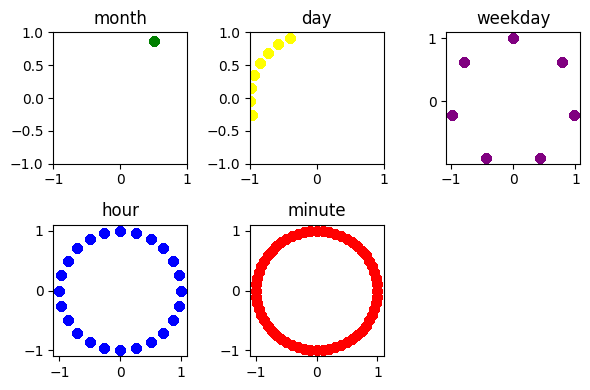

In [90]:
plt.figure(figsize=(3*2, 2*2))
plt.subplot(2, 3, 1)
plt.title("month")
plt.scatter(df["month_sin"], df["month_cos"], color="green")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.subplot(2, 3, 2)
plt.title("day")
plt.scatter(df["day_sin"], df["day_cos"], color="yellow")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.subplot(2, 3, 3)
plt.title("weekday")
plt.scatter(df["weekday_sin"], df["weekday_cos"], color="purple")
plt.subplot(2, 3, 4)
plt.title("hour")
plt.scatter(df["hour_sin"], df["hour_cos"], color="blue")
plt.subplot(2, 3, 5)
plt.title("minute")
plt.scatter(df["minute_sin"], df["minute_cos"], color="red")
plt.tight_layout()

plt.show()

- `petition`: Before they were strings like "GET". We applied one-hot encoding and now we have `petition_GET`, `petition_HEAD`, `petition_POST`, which are the 3 most common, and `petition_other` for the rest. Each log will have a 1 on only one of this columns, 0 for the rest.

- `status`: Before they were integers like 404, 200... We took only the first digit (we considered the other two were not that relevant and were noise that could potentially damage the model), and made one-hot encoding. Now we have `status_1`, `status_2`, `status_3`, `status_4`, `status_5`. Each log will have a 1 on only one of this columns, 0 for the rest.